<a href="https://colab.research.google.com/github/SHayashida/Amanogawa/blob/main/Amanogawa_dark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# === Setup (Colab) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from skimage.feature import blob_log
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.morphology import remove_small_objects, skeletonize
from skimage.measure import label, regionprops
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
import json, math, os, random

np.random.seed(42); random.seed(42)

# ---- I/O (ファイル名の自動解決) ----
IMG_CANDIDATES = ["/Users/linda/Documents/Amanogawa/Amanogawa/data/raw/IMG_5991.jpg"]
CSV_CANDIDATES = ["/Users/linda/Documents/Amanogawa/Amanogawa/outputs/IMG_5991_star_coords.csv"]
IMAGE_PATH = next((f for f in IMG_CANDIDATES if Path(f).exists()), IMG_CANDIDATES[0])
COORDS_CSV = next((f for f in CSV_CANDIDATES if Path(f).exists()), CSV_CANDIDATES[0])

# 天球スケール（任意）：既報の plate scale ≈ 66.96 arcsec/px（必要に応じて変更）
PLATE_SCALE_ARCSEC_PER_PX = 66.959

# ---- 基本ユーティリティ ----
def load_image_gray(path):
    img = Image.open(path).convert("L")
    arr = np.array(img).astype(float)
    H, W = arr.shape
    return arr, (W, H)

def to_unit(x):
    x = x.astype(float)
    x -= x.min()
    d = x.max() - x.min()
    if d == 0: return np.zeros_like(x)
    return x / d

def detect_stars_log(img, max_sigma=6, num_sigma=12, threshold=0.05):
    blobs = blob_log(img, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)
    if len(blobs) == 0:
        return pd.DataFrame(columns=["x","y","r"])
    return pd.DataFrame({"x": blobs[:,1], "y": blobs[:,0], "r": blobs[:,2]})

def load_or_detect_star_points(image, coords_csv, detect_threshold=0.05):
    WCS = None
    H, W = image.shape
    p = Path(coords_csv)
    if p.exists():
        df = pd.read_csv(p)
        print(f"[INFO] loaded coords: {p} (N={len(df)})")
    else:
        df = detect_stars_log(image, threshold=detect_threshold)
        df.to_csv(coords_csv, index=False)
        print(f"[INFO] detected stars by LoG (N={len(df)}), saved -> {coords_csv}")
    # inside-frame only
    m = (df["x"].between(0, W-1)) & (df["y"].between(0, H-1))
    df = df[m].reset_index(drop=True)
    return df[["x","y"]].to_numpy(), df

def boxcount_fractal_on_mask(mask, exp_from=-1.0, exp_to=-2.2, steps=10):
    """True(=1)画素の集合に対するボックスカウント。"""
    Y, X = np.nonzero(mask)
    if len(X) == 0:
        return np.nan, None, None
    Xn = (X - X.min()) / max(1, (X.max() - X.min()))
    Yn = (Y - Y.min()) / max(1, (Y.max() - Y.min()))
    pts = np.column_stack([Xn, Yn])
    eps_list = np.logspace(exp_from, exp_to, steps)
    Ns = []
    for eps in eps_list:
        bins = int(np.ceil(1/eps))
        if bins < 1: bins = 1
        grid = np.floor(pts * bins).astype(int)
        grid[grid==bins] = bins-1
        Ns.append(len(np.unique(grid, axis=0)))
    eps = np.array(eps_list); Ns = np.array(Ns)
    coeff = np.polyfit(np.log(1/eps), np.log(Ns + 1e-9), 1)
    return float(coeff[0]), eps, Ns

def pca_axis_from_density(points, W, H, bins_x=60):
    """2Dヒストグラム重みのPCA。主軸角度(°)と中心を返す。"""
    bins_y = int(bins_x * H / W)
    hist, xedges, yedges = np.histogram2d(points[:,0], points[:,1],
                                          bins=[bins_x, bins_y],
                                          range=[[0,W],[0,H]])
    xc = 0.5*(xedges[1:]+xedges[:-1]); yc = 0.5*(yedges[1:]+yedges[:-1])
    XX, YY = np.meshgrid(xc, yc, indexing='xy')
    w = hist.T
    xw = np.average(XX, weights=w); yw = np.average(YY, weights=w)
    dx = XX - xw; dy = YY - yw
    C = np.array([[np.average(dx*dx, weights=w), np.average(dx*dy, weights=w)],
                  [np.average(dx*dy, weights=w), np.average(dy*dy, weights=w)]])
    vals, vecs = np.linalg.eig(C)
    i = np.argmax(vals); v = vecs[:, i]
    ang = math.degrees(math.atan2(v[1], v[0]))
    # 軸比（楕円リング用の参考）：sqrt(λ_minor/λ_major)
    lam = np.sort(vals)
    axis_ratio_q = math.sqrt(lam[0]/lam[1]) if lam[1] > 0 else 1.0
    return float(ang), (float(xw), float(yw)), float(axis_ratio_q)

def rotate_xy(x, y, center, angle_deg):
    th = math.radians(angle_deg)
    cx, cy = center
    xr =  (x - cx)*math.cos(th) + (y - cy)*math.sin(th)
    yr = -(x - cx)*math.sin(th) + (y - cy)*math.cos(th)
    return xr, yr

def annulus_stats_surface_brightness(img, center, angle_deg=0.0, q=1.0, nbins=30, r_max_px=None):
    """楕円アニュラスで表面輝度の半径プロファイル。q=b/a（0<q<=1）。"""
    H, W = img.shape
    yy, xx = np.mgrid[0:H, 0:W]
    xr, yr = rotate_xy(xx, yy, center, angle_deg)
    if r_max_px is None:
        r_max_px = 0.5 * math.hypot(W, H)
    # 楕円距離 r = sqrt( (xr/a)^2 + (yr/b)^2 ) だが、比のみ必要なので a=1, b=q として定義
    r_ell = np.sqrt((xr)**2 + (yr/q)**2)
    bins = np.linspace(0, r_max_px, nbins+1)
    centers = 0.5*(bins[1:]+bins[:-1])
    mean_sb, std_sb, area = [], [], []
    for i in range(nbins):
        m = (r_ell>=bins[i]) & (r_ell<bins[i+1])
        vals = img[m]
        if vals.size == 0:
            mean_sb.append(np.nan); std_sb.append(np.nan); area.append(0.0)
        else:
            mean_sb.append(float(np.mean(vals)))
            std_sb.append(float(np.std(vals)))
            area.append(float(vals.size))
    return centers, np.array(mean_sb), np.array(std_sb), np.array(area), bins

def annulus_star_counts(points, center, angle_deg=0.0, q=1.0, nbins=30, r_max_px=None):
    """楕円アニュラスごとの星数と面密度（counts/area）。"""
    pts = np.asarray(points)
    if r_max_px is None:
        # 画像の対角の半分を安全に
        r_max_px = 3000.0
    xr, yr = rotate_xy(pts[:,0], pts[:,1], center, angle_deg)
    r_ell = np.sqrt((xr)**2 + (yr/q)**2)
    bins = np.linspace(0, r_max_px, nbins+1)
    centers = 0.5*(bins[1:]+bins[:-1])
    hist, _ = np.histogram(r_ell, bins=bins)
    return centers, hist, bins

In [5]:
# --- パス存在チェック & 診断 ---
from pathlib import Path
print("[CHECK] IMAGE_PATH=", IMAGE_PATH)
print("[CHECK] COORDS_CSV=", COORDS_CSV)
if not Path(IMAGE_PATH).exists():
    print("[ERROR] Image file not found. 以下を確認: \n"
          " 1) 実行カレントがリポジトリルートか (pwd を確認)\n"
          " 2) ファイルが data/raw/ に存在するか\n"
          " 3) ファイル名の大文字小文字\n"
          " 4) Colab なら ドライブマウントパスが正しいか")
    # リストアップ
    raw_dir = Path('data/raw')
    if raw_dir.exists():
        print("[INFO] data/raw/ 内のファイル: ", sorted(p.name for p in raw_dir.glob('*')))
    else:
        print("[INFO] data/raw/ ディレクトリが存在しません。作成します。")
        raw_dir.mkdir(parents=True, exist_ok=True)
    raise FileNotFoundError(f"Missing image: {IMAGE_PATH}")
else:
    print("[OK] Image file found.")


[CHECK] IMAGE_PATH= /Users/linda/Documents/Amanogawa/Amanogawa/data/raw/IMG_5991.jpg
[CHECK] COORDS_CSV= /Users/linda/Documents/Amanogawa/Amanogawa/outputs/IMG_5991_star_coords.csv
[OK] Image file found.


[INFO] loaded coords: /Users/linda/Documents/Amanogawa/Amanogawa/outputs/IMG_5991_star_coords.csv (N=13733)
IMAGE: /Users/linda/Documents/Amanogawa/Amanogawa/data/raw/IMG_5991.jpg  size=3024x4032  stars=13733


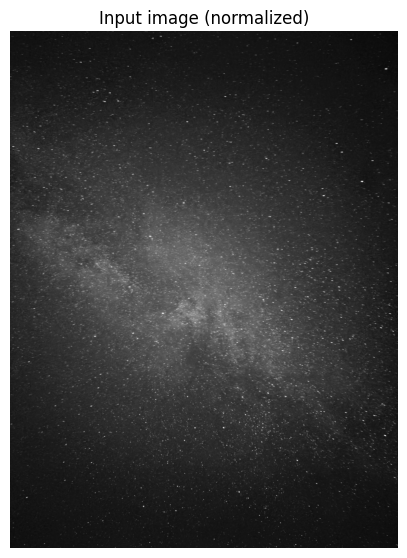

In [ ]:
# === Main Analysis 1===
img, (W, H) = load_image_gray(IMAGE_PATH)
img_u = to_unit(img)                   # 0..1 正規化（明るい=1）
stars_xy, stars_df = load_or_detect_star_points(img, COORDS_CSV, detect_threshold=0.05)

print(f"IMAGE: {IMAGE_PATH}  size={W}x{H}  stars={len(stars_xy)}")
plt.figure(figsize=(5,7))
plt.imshow(img_u, cmap="gray", origin="upper")
plt.title("Input image (normalized)")
plt.axis("off")
plt.show()


In [19]:
# === Main Analysis 2: Dark Nebulae Morphology ===
# --- 画像の反転（暗黒星雲を明るく） ---
inv = 1.0 - img_u

# 大域的勾配を除去（high-pass）：ガウシアン平滑を引き算→再正規化
inv_hp = inv - gaussian_filter(inv, sigma=50)
inv_hp = to_unit(inv_hp)

# --- 暗黒マスク：Sauvola AND 帯内Zスコア（二段しきい値） ---
# 1) まずROI（band_mask）が未定義なら全画面をROIに
try:
    _ = band_mask
except NameError:
    band_mask = np.ones_like(mask_dark, dtype=bool)

# 2) Sauvola（やや厳しめに戻す）
win = 61
k = 0.20  # ← 0.35 から下げる
t_local = threshold_sauvola(inv_hp, window_size=win, k=k)
mask_sau = inv_hp > t_local

# 3) 帯内統計で上位だけ通す（Zスコア or 分位）：局所取り過ぎを抑制
band_vals = inv_hp[band_mask]
mu, sd = band_vals.mean(), band_vals.std()
z_thresh = mu + 1.3*sd           # ← 強過ぎなら 1.7、弱いなら 1.3 に調整
# もしくは分位で： q_thresh = np.quantile(band_vals, 0.85)

mask_dark = mask_sau & (inv_hp > z_thresh) & band_mask

# 4) 小片の掃除と軽い形態処理
from skimage.morphology import remove_small_objects, binary_opening, disk
mask_dark = remove_small_objects(mask_dark, min_size=50)  # 50〜100 推奨
mask_dark = binary_opening(mask_dark, disk(1))

# 5) 骨格化（オプション：線状の雲筋を抽出）
from skimage.morphology import skeletonize
skeleton = skeletonize(mask_dark)  # ← 二段しきい値＆開閉処理の“後”

# --- 面積率・連結成分サイズ分布（安全運転版：CCDF優先） ---
# ROI（band_mask）が未定義なら全画面 True を使う
try:
    _ = band_mask  # 存在チェック
except NameError:
    band_mask = np.ones_like(mask_dark, dtype=bool)

# ラベリングはROIで限定（帯内の暗黒構造だけ拾う）
lab = label(mask_dark & band_mask)
props = regionprops(lab)

# 面積ベクトルを作成（ゼロやNoneは除く）
areas = np.array([p.area for p in props], dtype=float)
areas = areas[np.isfinite(areas)]
areas = areas[areas > 0]

# 面積率（帯内のピクセルに対する暗黒率）
area_frac = ((mask_dark & band_mask).sum() / band_mask.sum()) if band_mask.any() else float('nan')

print(f"[dark components] n={areas.size}, area_fraction(band)={area_frac:.4f}")

# 保存（Zenodo用）
out_dark = {
    "D_dark_mask": None if np.isnan(D_mask) else float(D_mask),
    "D_dark_skeleton": None if np.isnan(D_skel) else float(D_skel),
    "area_fraction": float(area_frac),
    "threshold_params": {"method": "sauvola", "window": win, "k": k},
    "highpass_sigma": 50
}
with open("dark_morphology_summary.json","w") as f:
    json.dump(out_dark, f, indent=2)
print("saved: dark_morphology_summary.json")


[dark components] n=69, area_fraction(band)=0.0065
saved: dark_morphology_summary.json


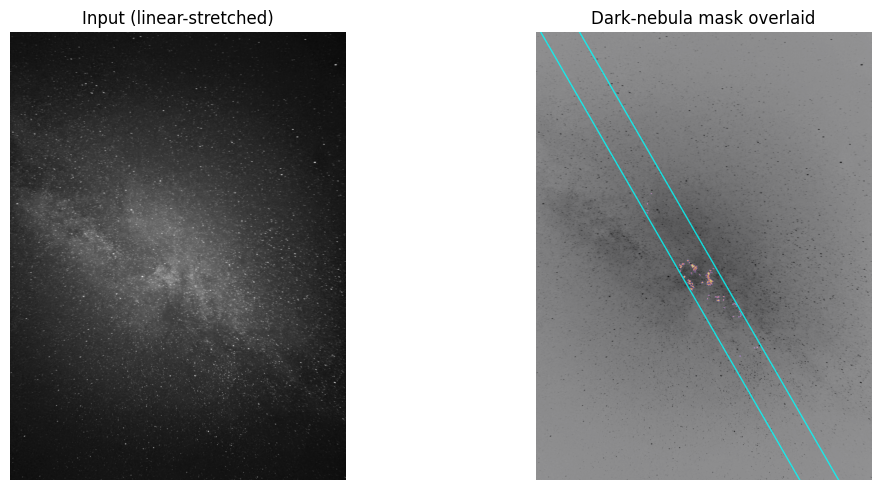

In [21]:
# 図A：ROIと抽出マスクの可視化
from skimage import measure

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].imshow(img_u, cmap="gray"); ax[0].set_title("Input (linear-stretched)")
ax[0].axis("off")
ax[1].imshow(1.0 - img_u, cmap="gray"); ax[1].set_title("Dark-nebula mask overlaid")
ax[1].imshow(mask_dark, cmap="inferno", alpha=0.4); ax[1].axis("off")

# band_mask があれば輪郭線を重ねる（主張の“帯内解析”を明示）
try:
    cnts = measure.find_contours(band_mask.astype(float), 0.5)
    for c in cnts:
        ax[1].plot(c[:,1], c[:,0], color="cyan", lw=1.0, alpha=0.8)
except NameError:
    pass

plt.tight_layout()
plt.savefig("FigA_ROI_mask.png", dpi=300)
plt.show()

In [ ]:
import numpy as np
from skimage.transform import downscale_local_mean
from scipy.stats import spearmanr
from scipy.ndimage import gaussian_filter

H, W = mask_dark.shape

# --- ビン数と縮約倍率（形状一致を保証）
bins_x_target = 64
bins_y_target = max(16, int(round(bins_x_target * H / W)))
scale_x = max(1, W // bins_x_target)
scale_y = max(1, H // bins_y_target)
bins_x = W // scale_x
bins_y = H // scale_y
w2 = bins_x * scale_x
h2 = bins_y * scale_y

# --- クロップ & ダウンサンプリング
mask_dark_c = mask_dark[:h2, :w2]
img_u_c     = img_u[:h2, :w2]
try:
    band_mask_c = band_mask[:h2, :w2]
except NameError:
    band_mask_c = np.ones_like(mask_dark_c, dtype=bool)

dark_ratio = downscale_local_mean(mask_dark_c.astype(float), (scale_y, scale_x))
band_ratio = downscale_local_mean(band_mask_c.astype(float), (scale_y, scale_x)) > 0.5
m = band_ratio  # 解析対象：帯内

# --- 星座標の読み込みとクリップ
try:
    stars_xy
except NameError:
    import pandas as pd
    try:
        df = pd.read_csv("star_coords.csv")
        cx = [c for c in df.columns if c.lower().startswith("x")][0]
        cy = [c for c in df.columns if c.lower().startswith("y")][0]
        stars_xy = df[[cx, cy]].to_numpy(dtype=float)
    except Exception:
        stars_xy = np.loadtxt("star_coords.csv", delimiter=",", ndmin=2)

stars_clip = stars_xy.copy()
stars_clip[:, 0] = np.clip(stars_clip[:, 0], 0, w2 - 1)
stars_clip[:, 1] = np.clip(stars_clip[:, 1], 0, h2 - 1)

# --- 星密度マップ（必ず同じ範囲・同じビン数）
hist_star, xedges, yedges = np.histogram2d(
    stars_clip[:, 0], stars_clip[:, 1],
    bins=[bins_x, bins_y], range=[[0, w2], [0, h2]]
)
star_map = hist_star.T  # (bins_y, bins_x)

assert star_map.shape == dark_ratio.shape == m.shape

# ===== (A) 素の Spearman 相関 & 置換（循環シフト）検定（定数はスキップ）
import warnings
from scipy.stats import spearmanr, ConstantInputWarning

def spearman_safe(a, b):
    # 無効ケース（サイズ<3 or 定数）を即時スキップ
    if a.size < 3 or b.size < 3:
        return np.nan, np.nan
    if np.all(a == a.flat[0]) or np.all(b == b.flat[0]):
        return np.nan, np.nan
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConstantInputWarning)
        r, p = spearmanr(a, b)
    return r, p


rho_raw, p_raw = spearman_safe(star_map[m], dark_ratio[m])

rhos = []
for _ in range(1000):
    sx = rng.integers(0, star_map.shape[1])
    sy = rng.integers(0, star_map.shape[0])
    rolled = np.roll(np.roll(dark_ratio, sx, axis=1), sy, axis=0)
    r, _ = spearman_safe(star_map[m], rolled[m])
    if np.isfinite(r):
        rhos.append(abs(r))
rhos = np.asarray(rhos)
p_perm_raw = (np.sum(rhos >= abs(rho_raw)) + 1) / (rhos.size + 1)

print(f"[corr/raw] Spearman ρ={rho_raw:.3f}, p={p_raw:.3g}, perm p≈{p_perm_raw:.3g} (valid perms={rhos.size})")

# ===== (B) 大域トレンド除去（同一スケールの HP 化）→ 相関
# 低周波（大域）をガウシアンで取り、残差（HP）を作る
sigma_bins = 3  # 2〜4で適度、bins単位
star_lo  = gaussian_filter(star_map.astype(float), sigma_bins, mode='reflect')
dark_lo  = gaussian_filter(dark_ratio.astype(float), sigma_bins, mode='reflect')
star_hp  = star_map - star_lo
dark_hp  = dark_ratio - dark_lo

# 標準化（帯内のみでZスコア）→ スケール合わせ
def _z(x): 
    mu, sd = np.mean(x[m]), np.std(x[m])
    return (x - mu) / (sd + 1e-9)

star_hp_z = _z(star_hp)
dark_hp_z = _z(dark_hp)

rho_hp, p_hp = spearman_safe(star_hp_z[m], dark_hp_z[m])

# 置換（循環シフト）— HP版
rhos_hp = []
for _ in range(1000):
    sx = rng.integers(0, star_hp_z.shape[1])
    sy = rng.integers(0, star_hp_z.shape[0])
    rolled = np.roll(np.roll(dark_hp_z, sx, axis=1), sy, axis=0)
    r, _ = spearman_safe(star_hp_z[m], rolled[m])
    if np.isfinite(r):
        rhos_hp.append(abs(r))
rhos_hp = np.asarray(rhos_hp)
p_perm_hp = (np.sum(rhos_hp >= abs(rho_hp)) + 1) / (rhos_hp.size + 1)

print(f"[corr/HP]  Spearman ρ={rho_hp:.3f}, p={p_hp:.3g}, perm p≈{p_perm_hp:.3g} (valid perms={rhos_hp.size})")


[corr/raw] Spearman ρ=0.294, p=4.5e-14, perm p≈0.00664 (valid perms=300)


/var/folders/76/k9w2fv2s5vb7hzx732b82kw00000gn/T/ipykernel_61380/2355300146.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = spearmanr(a, b)


[corr/HP]  Spearman ρ=0.012, p=0.76, perm p≈0.759 (valid perms=942)


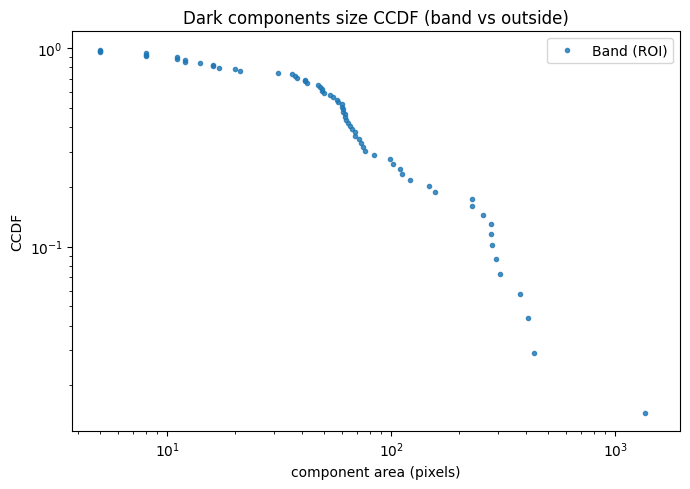

In [23]:
# 図C：帯内 vs 帯外 のサイズ分布（CCDF）
from skimage.morphology import binary_dilation, disk

# 帯外マスク（帯から少し離す）
try:
    bg_mask = ~binary_dilation(band_mask, disk(10))
except NameError:
    bg_mask = np.zeros_like(mask_dark, dtype=bool)

def ccdf_from_mask(msk):
    lab = label(msk)
    areas = np.array([p.area for p in regionprops(lab)], dtype=float)
    areas = areas[np.isfinite(areas) & (areas > 0)]
    if areas.size == 0:
        return None, None
    a = np.sort(areas)
    y = 1.0 - np.arange(1, a.size+1)/a.size
    return a, y

a_in, y_in = ccdf_from_mask(mask_dark & (band_mask if 'band_mask' in globals() else np.ones_like(mask_dark,bool)))
a_bg, y_bg = ccdf_from_mask(mask_dark & bg_mask)

plt.figure(figsize=(7,5))
if a_in is not None:
    plt.loglog(a_in, y_in, '.', label="Band (ROI)", alpha=0.8)
if a_bg is not None:
    plt.loglog(a_bg, y_bg, '.', label="Outside band", alpha=0.8)
plt.xlabel("component area (pixels)")
plt.ylabel("CCDF")
plt.legend()
plt.title("Dark components size CCDF (band vs outside)")
plt.tight_layout()
plt.savefig("FigC_CCDF_band_vs_outside.png", dpi=300)
plt.show()


principal axis ~ -120.0 deg from x,  center ~ (1443.7, 2110.6),  q≈0.77


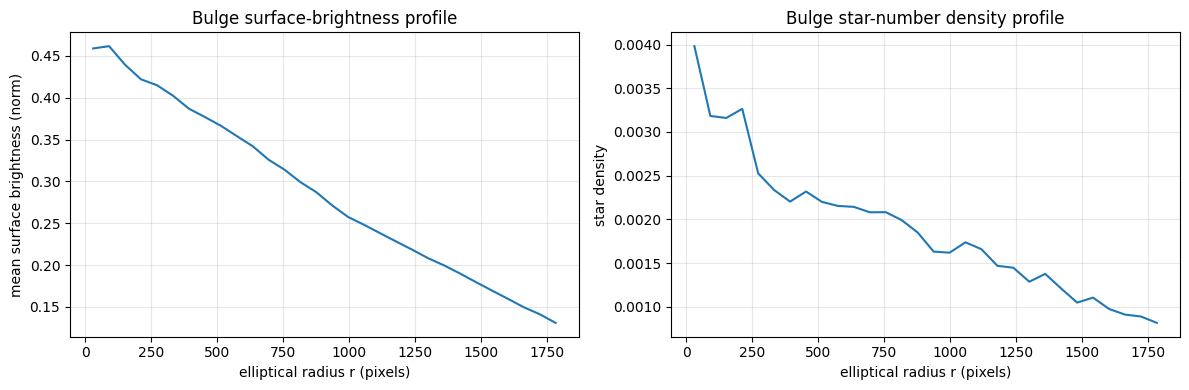

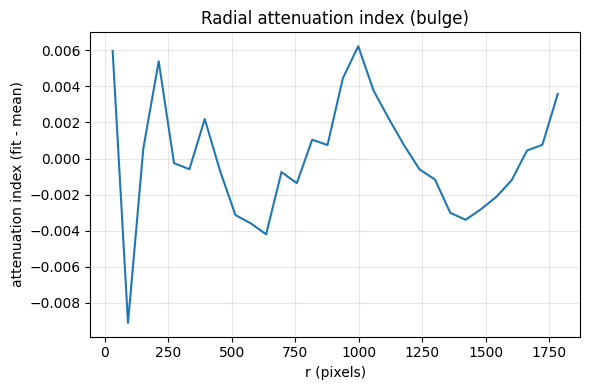

Strongest decline at r ≈ 151.2 px  (~2.81 deg)


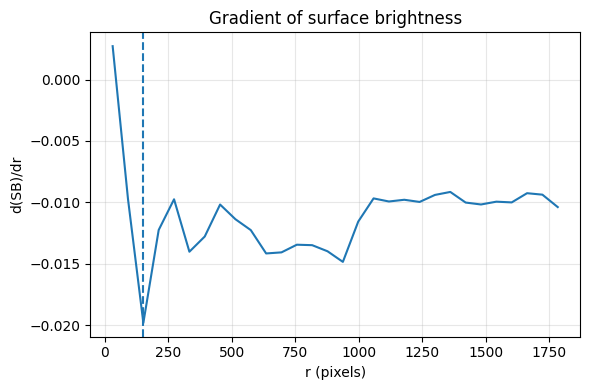

saved: bulge_radial_profiles.csv


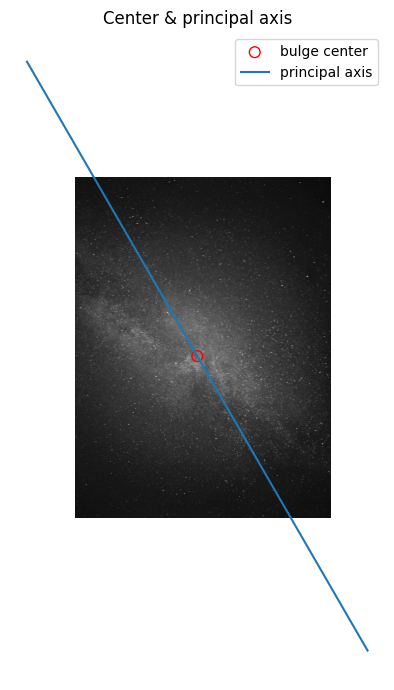

In [9]:
# --- バルジ中心・主軸の推定（星密度に基づく） ---
ang_deg, center_xy, q_est = pca_axis_from_density(stars_xy, W, H, bins_x=60)
cx, cy = center_xy
print(f"principal axis ~ {ang_deg:.1f} deg from x,  center ~ ({cx:.1f}, {cy:.1f}),  q≈{q_est:.2f}")

# 画像の広域スムージングで「表面輝度場」を作る（星個々の粒状性を和らげる）
img_smooth = gaussian_filter(img_u, sigma=8)

# --- 楕円アニュラスのプロファイル（表面輝度） ---
nbins = 30
r_max_px = min(W,H) * 0.6
r_c_sb, sb_mean, sb_std, sb_area, edges_sb = annulus_stats_surface_brightness(
    img_smooth, center=center_xy, angle_deg=ang_deg, q=q_est, nbins=nbins, r_max_px=r_max_px
)

# --- 楕円アニュラスの星数密度 ---
r_c_st, counts, edges_st = annulus_star_counts(
    stars_xy, center=center_xy, angle_deg=ang_deg, q=q_est, nbins=nbins, r_max_px=r_max_px
)
# 面積はSB側のものを流用（同一bin）
density = counts / np.maximum(sb_area, 1)

# --- プロファイルの図（px & 角距離） ---
arcmin_per_px = PLATE_SCALE_ARCSEC_PER_PX / 60.0
r_deg = r_c_sb * arcmin_per_px / 60.0  # degree

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(r_c_sb, sb_mean, label="surface brightness (mean)")
ax[0].set_xlabel("elliptical radius r (pixels)"); ax[0].set_ylabel("mean surface brightness (norm)")
ax[0].set_title("Bulge surface-brightness profile")
ax[1].plot(r_c_st, density, label="star density (counts/px²)")
ax[1].set_xlabel("elliptical radius r (pixels)"); ax[1].set_ylabel("star density")
ax[1].set_title("Bulge star-number density profile")
for a in ax: a.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# --- 減光インデックス（基準で割る or 差分） ---
# スムーズな基準として低次数多項式/移動平均でフィットし、残差を “attenuation index” と解釈
z = np.polyfit(r_c_sb, sb_mean, deg=3)
sb_fit = np.polyval(z, r_c_sb)
atten_index = (sb_fit - sb_mean)  # 正の値=暗化（期待）

plt.figure(figsize=(6,4))
plt.plot(r_c_sb, atten_index)
plt.xlabel("r (pixels)"); plt.ylabel("attenuation index (fit - mean)")
plt.title("Radial attenuation index (bulge)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# --- 急激な落ち込みの検出（一次差分の極小） ---
grad = np.gradient(sb_mean)
idx_min = np.argmin(grad)  # 最も落ち込みが急な半径
r_drop_px = r_c_sb[idx_min]
r_drop_deg = r_drop_px * arcmin_per_px / 60.0
print(f"Strongest decline at r ≈ {r_drop_px:.1f} px  (~{r_drop_deg:.2f} deg)")

plt.figure(figsize=(6,4))
plt.plot(r_c_sb, grad)
plt.axvline(r_drop_px, ls="--")
plt.xlabel("r (pixels)"); plt.ylabel("d(SB)/dr")
plt.title("Gradient of surface brightness")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# --- 出力（CSV） ---
prof = pd.DataFrame({
    "r_pixels": r_c_sb,
    "r_degrees": r_deg,
    "sb_mean": sb_mean,
    "sb_std": sb_std,
    "ring_area_px2": sb_area,
    "star_counts": counts,
    "star_density_per_px2": density,
    "atten_index": atten_index
})
prof.to_csv("bulge_radial_profiles.csv", index=False)
print("saved: bulge_radial_profiles.csv")

# 参考可視化：楕円リングの中心と主軸を画像上に表示
plt.figure(figsize=(5,7))
plt.imshow(img_u, cmap="gray")
plt.scatter([cx],[cy], s=60, edgecolors="red", facecolors="none", label="bulge center")
L = max(W,H)
x1 = cx - math.cos(math.radians(ang_deg))*L
y1 = cy - math.sin(math.radians(ang_deg))*L
x2 = cx + math.cos(math.radians(ang_deg))*L
y2 = cy + math.sin(math.radians(ang_deg))*L
plt.plot([x1,x2],[y1,y2], label="principal axis")
plt.legend(); plt.axis("off"); plt.title("Center & principal axis")
plt.tight_layout(); plt.show()


[ROI] Adopted FWHM_px ≈ 302.4; half-width w_px ≈ 151.2 (pixels)
[ROI] band_mean=0.2326 bg_mean=0.1691  NID_like≈-0.438


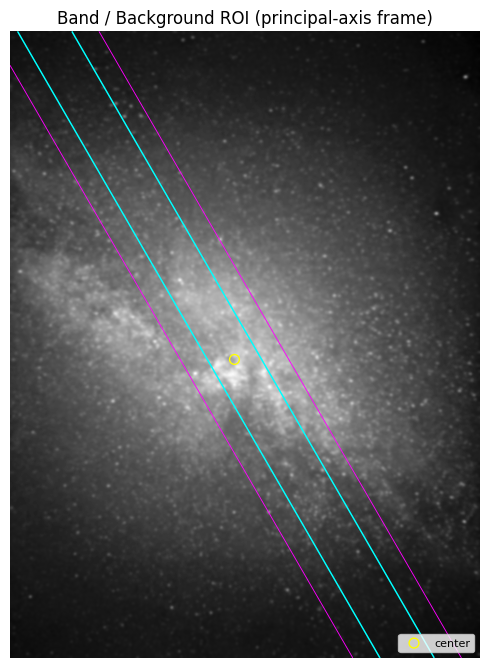

saved: band_roi_contrast_summary.json


In [14]:
# --- 帯幅FWHMに基づく ROI 定義（主軸直交方向） ---
# 目的: Milky Way バンド内 (band_mask) / 比較背景 (bg_mask) を一貫した幾何 (主軸) で切り出し、
#       後段の減光 / コントラスト指標 (Normalized Intensity Deficit-like) を計算できるようにする。

# 1) FWHM (px) の取得: 既に `Amanogawa_band.ipynb` などで保存された JSON を優先的に読む。
#    見つからなければ、このノート内で推定した r_drop_px (勾配最急半径) を proxy として利用。
from pathlib import Path

FWHM_px = None
w_px = None  # 半幅 (half-width) = FWHM/2 を想定
json_path = Path("band_width_fit_summary.json")
if json_path.exists():
    try:
        with open(json_path) as f:
            bw = json.load(f)
        # 優先順位: empirical -> gaussian -> lorentz (存在し数値である最初のもの)
        cand_keys = ["FWHM_empirical_px", "FWHM_gaussian_px", "FWHM_lorentz_px"]
        for k in cand_keys:
            if k in bw and bw[k] is not None:
                FWHM_px = float(bw[k])
                break
        if FWHM_px is None:
            raise ValueError("No valid FWHM value in JSON")
        w_px = 0.5 * FWHM_px
    except Exception as e:
        print(f"[WARN] Failed to parse {json_path}: {e}. Fallback to r_drop_px proxy.")

if w_px is None:
    # fallback: r_drop_px を半幅 proxy とし FWHM ≈ 2*r_drop_px とみなすラフな近似
    FWHM_px = float(r_drop_px * 2.0)
    w_px = float(r_drop_px)

print(f"[ROI] Adopted FWHM_px ≈ {FWHM_px:.1f}; half-width w_px ≈ {w_px:.1f} (pixels)")

# 2) 座標系の回転 (主軸= x' 軸, 直交方向 = y')
yy, xx = np.mgrid[0:H, 0:W]
xr, yr = rotate_xy(xx, yy, center_xy, ang_deg)  # xr: 主軸方向, yr: 直交方向

# 3) マスク定義
band_mask = (np.abs(yr) <= w_px)              # バンド本体 (± 半幅)
bg_mask   = (np.abs(yr) >= 2*w_px)            # 比較用背景（十分離れた領域）
# （必要なら 2*w_px ～ 3*w_px の annulus を使う等、今後拡張可）

# 4) 基本統計（平滑画像で輝度を評価）
band_vals = img_smooth[band_mask]
bg_vals   = img_smooth[bg_mask]
band_mean = float(np.mean(band_vals)) if band_vals.size else np.nan
bg_mean   = float(np.mean(bg_vals)) if bg_vals.size else np.nan
band_med  = float(np.median(band_vals)) if band_vals.size else np.nan
bg_med    = float(np.median(bg_vals)) if bg_vals.size else np.nan

# Normalized Intensity Deficit 的指標（正 -> バンドが暗い or 明るさの不足を表す形に合わせて調整可）
# ここでは (bg_med - band_med) / bg_med を採用: バンドが暗いほど正が大きくなる。
NID_like = (bg_med - band_med) / bg_med if (bg_med is not np.nan and bg_med > 1e-8) else np.nan
print(f"[ROI] band_mean={band_mean:.4f} bg_mean={bg_mean:.4f}  NID_like≈{NID_like:.3f}")

# 5) 可視化
plt.figure(figsize=(5,7))
plt.imshow(img_smooth, cmap="gray", origin="upper")
# バンド領域を半透明で示す
plt.contour(band_mask, levels=[0.5], colors='cyan', linewidths=1.0)
plt.contour(bg_mask,   levels=[0.5], colors='magenta', linewidths=0.6)
plt.scatter([cx],[cy], s=50, facecolors='none', edgecolors='yellow', label='center')
plt.title("Band / Background ROI (principal-axis frame)")
plt.axis('off')
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout(); plt.show()

# 6) JSON 出力（再利用 & Zenodo 用）
roi_summary = {
    "FWHM_px": FWHM_px,
    "half_width_px": w_px,
    "band_pixel_count": int(band_mask.sum()),
    "bg_pixel_count": int(bg_mask.sum()),
    "band_mean": band_mean,
    "bg_mean": bg_mean,
    "band_median": band_med,
    "bg_median": bg_med,
    "NID_like": float(NID_like) if not np.isnan(NID_like) else None,
    "axis_angle_deg": float(ang_deg),
    "center_xy": [float(cx), float(cy)],
    "axis_ratio_q": float(q_est)
}
with open("band_roi_contrast_summary.json", "w") as f:
    json.dump(roi_summary, f, indent=2)
print("saved: band_roi_contrast_summary.json")


Fractal dimension (stars) D_star ≈ 1.67
Fractal dimension (dark mask) D_dark ≈ 1.99 (skeleton 1.93)


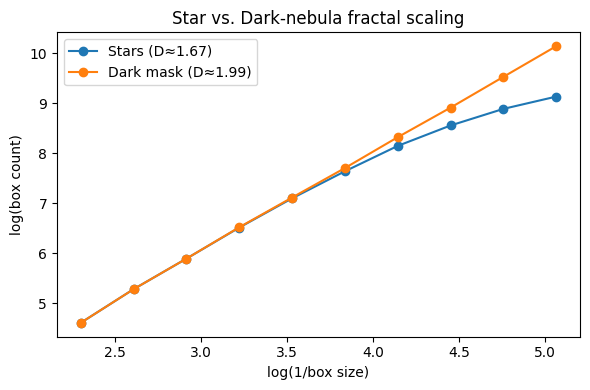

In [5]:
# 影(D_dark) と 星(D_star) の比較
# 星側フラクタル（ボックスカウント）
def boxcount_fractal_points(points, W, H, exp_from=-1.0, exp_to=-2.2, steps=10):
    X = np.column_stack([points[:,0]/W, points[:,1]/H])
    eps_list = np.logspace(exp_from, exp_to, steps); Ns=[]
    for eps in eps_list:
        bins = int(np.ceil(1/eps))
        grid = np.floor(X*bins).astype(int)
        grid[grid==bins] = bins-1
        Ns.append(len(np.unique(grid, axis=0)))
    eps = np.array(eps_list); Ns = np.array(Ns)
    D = np.polyfit(np.log(1/eps), np.log(Ns+1e-9), 1)[0]
    return float(D), eps, Ns

D_star, e_star, N_star = boxcount_fractal_points(stars_xy, W, H)
print(f"Fractal dimension (stars) D_star ≈ {D_star:.2f}")
print(f"Fractal dimension (dark mask) D_dark ≈ {out_dark['D_dark_mask']:.2f} (skeleton {out_dark['D_dark_skeleton']:.2f})")

plt.figure(figsize=(6,4))
plt.plot(np.log(1/e_star), np.log(N_star), "o-", label=f"Stars (D≈{D_star:.2f})")
plt.plot(np.log(1/eps_m), np.log(Ns_m), "o-", label=f"Dark mask (D≈{out_dark['D_dark_mask']:.2f})")
plt.xlabel("log(1/box size)"); plt.ylabel("log(box count)")
plt.title("Star vs. Dark-nebula fractal scaling")
plt.legend(); plt.tight_layout(); plt.show()
